# Optimization of Rosenbrock Function

## Deatiled comparison of SGD and LBGFS

As often remarked, optimization is at the core of inverse problems and machine learning. It will often be necessary to examine in detail the progress and the convergence behavior of different optimization algorithms. This is a common event, given the inherent difficulties in minimizing the ill-posed problems we will face in real life.

In this example, we study a well-known test function, the Rosenbrock function, that has a very narrow "valley" around its minimal value. This topography is difficult to negotiate with many methods.

We use the classical `pytorch` steps, already seen above in a simpler 1D optimization example.

0. Define the function to be optimized.
1. Declare the differentiable optimization parameter.
2. Define the optimizer.
3. In the loop: 
   - set the gradient to zero
   - evaluate the objective (or loss) at the current point
   - use the `backward` operator to compute the gradient
   - update the epoch/iteration with the `step` operator
   - (eventually) save the iteration hisroty and print out convergence diagnostics

Solving with LBFGS
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
          1  |  8.101e+05  |  3.605e+05  |  3.7426e-01  |          2  |  1.000e+00  
          2  |  1.431e+04  |  2.268e+04  |  1.7323e-01  |          3  |  1.000e+00  
          3  |  7.935e+02  |  3.161e+03  |  4.2831e-02  |          4  |  1.000e+00  
          4  |  4.965e+00  |  1.709e+01  |  2.2943e-04  |          5  |  1.000e+00  
          5  |  4.949e+00  |  4.244e+00  |  4.5147e-05  |          6  |  1.000e+00  
          6  |  4.948e+00  |  6.826e-01  |  3.0575e-04  |          7  |  1.000e+00  
          7  |  4.946e+00  |  4.581e+00  |  3.4255e-01  |          8  |  1.000e+00  
          8  |  2.610e+00  |  2.890e+01  |  3.8115e-01  |          9  |  1.000e+00  
          9  |  1.063e+00  |  1.752e+01  |  7.6083e-03  |         10  |  1.000e+00  
         10  |  1.035e+00  |  1.043e+00  |  1.46

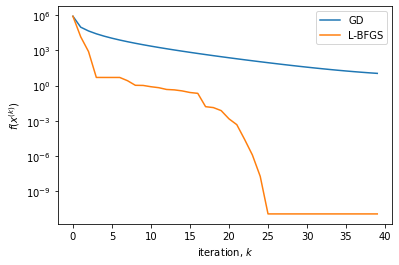

In [2]:
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Rosenbrock-like function
def f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# print('===================================================================================')
# print('Solving with SGD' )
# print('===================================================================================')
# print('    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    ')
# print('-----------------------------------------------------------------------------------')

func_evals = 0
tol_it_max = 40 #100

# Gradient descent
x_gd = 10*torch.ones(2, 1)
x_gd.requires_grad = True

optimizer = optim.SGD([x_gd], lr=1e-5)
h_gd = []
for n_iter in range(tol_it_max):
    optimizer.zero_grad()
    objective = f(x_gd)
    objective.backward()
    optimizer.step()
    h_gd.append(objective.item())
    # compute quantities for checking convergence
    # grad_norm = torch.norm(grad)
    # x_dist = torch.norm(x_new - x_old)/torch.norm(x_old)
    # f_dist = torch.abs(obj - f_old)/torch.max(torch.tensor(1, dtype=torch.float), torch.abs(f_old))


# L-BFGS
x_lbfgs = 10*torch.ones(2, 1)
x_lbfgs.requires_grad = True

print('===================================================================================')
print('Solving with LBFGS' )
print('===================================================================================')
print('    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    ')
print('-----------------------------------------------------------------------------------')

func_evals = 0


optimizer = optim.LBFGS([x_lbfgs],
                        history_size=10,
                        max_iter=4,
                        line_search_fn="strong_wolfe")#,
                        #verbose=True)
optimizer.zero_grad()
obj = f(x_lbfgs)
obj.backward()
#grad = f.grad()
grad = x_lbfgs.grad
func_evals += 1

#x_old = f.x().clone()
#x_new = x_old.clone()
x_old = x_lbfgs.clone()
x_new = x_old.clone()
f_old = obj

out = True
h_lbfgs = []    
t = time.process_time()
for n_iter in range(tol_it_max):
    optimizer.zero_grad()
    obj = f(x_lbfgs)
    obj.backward()
    optimizer.step(lambda: f(x_lbfgs))
    h_lbfgs.append(obj.item())

    #x_new.copy_(f.x())
    x_new.copy_(x_lbfgs)

    func_evals += 1 #clos_evals
    clos_evals = func_evals # for the moment
    lr = 1 # for the moment

    # compute quantities for checking convergence
    grad_norm = torch.norm(grad)
    x_dist = torch.norm(x_new - x_old)/torch.norm(x_old)
    f_dist = torch.abs(obj - f_old)/torch.max(torch.tensor(1, dtype=torch.float), torch.abs(f_old))

    # print data
    if(out):
        print('  %9d  |  %.3e  |  %.3e  |  %.4e  |  %9d  |  %.3e  ' %(n_iter+1, obj.item(), grad_norm.item(), x_dist.item(),  clos_evals, lr))

    x_old.copy_(x_new)
    f_old.copy_(obj)

t = time.process_time() - t  
# print summary
print('\n==================================== Summary ======================================')
print('Problem: LBFGS')
print('Iterations:', n_iter+1)
print('Function Evaluations:', func_evals)
print('Time:', t)
print('F:', obj.item())
print('||g||:', torch.norm(grad).item())
print('===================================================================================')


# Plotting
plt.semilogy(h_gd, label='GD')
plt.semilogy(h_lbfgs, label='L-BFGS')
plt.xlabel('iteration, $k$')
plt.ylabel('$f(x^{(k)})$')
plt.legend()
plt.show()
#plt.savefig("simple_conv.png", dpi=300)